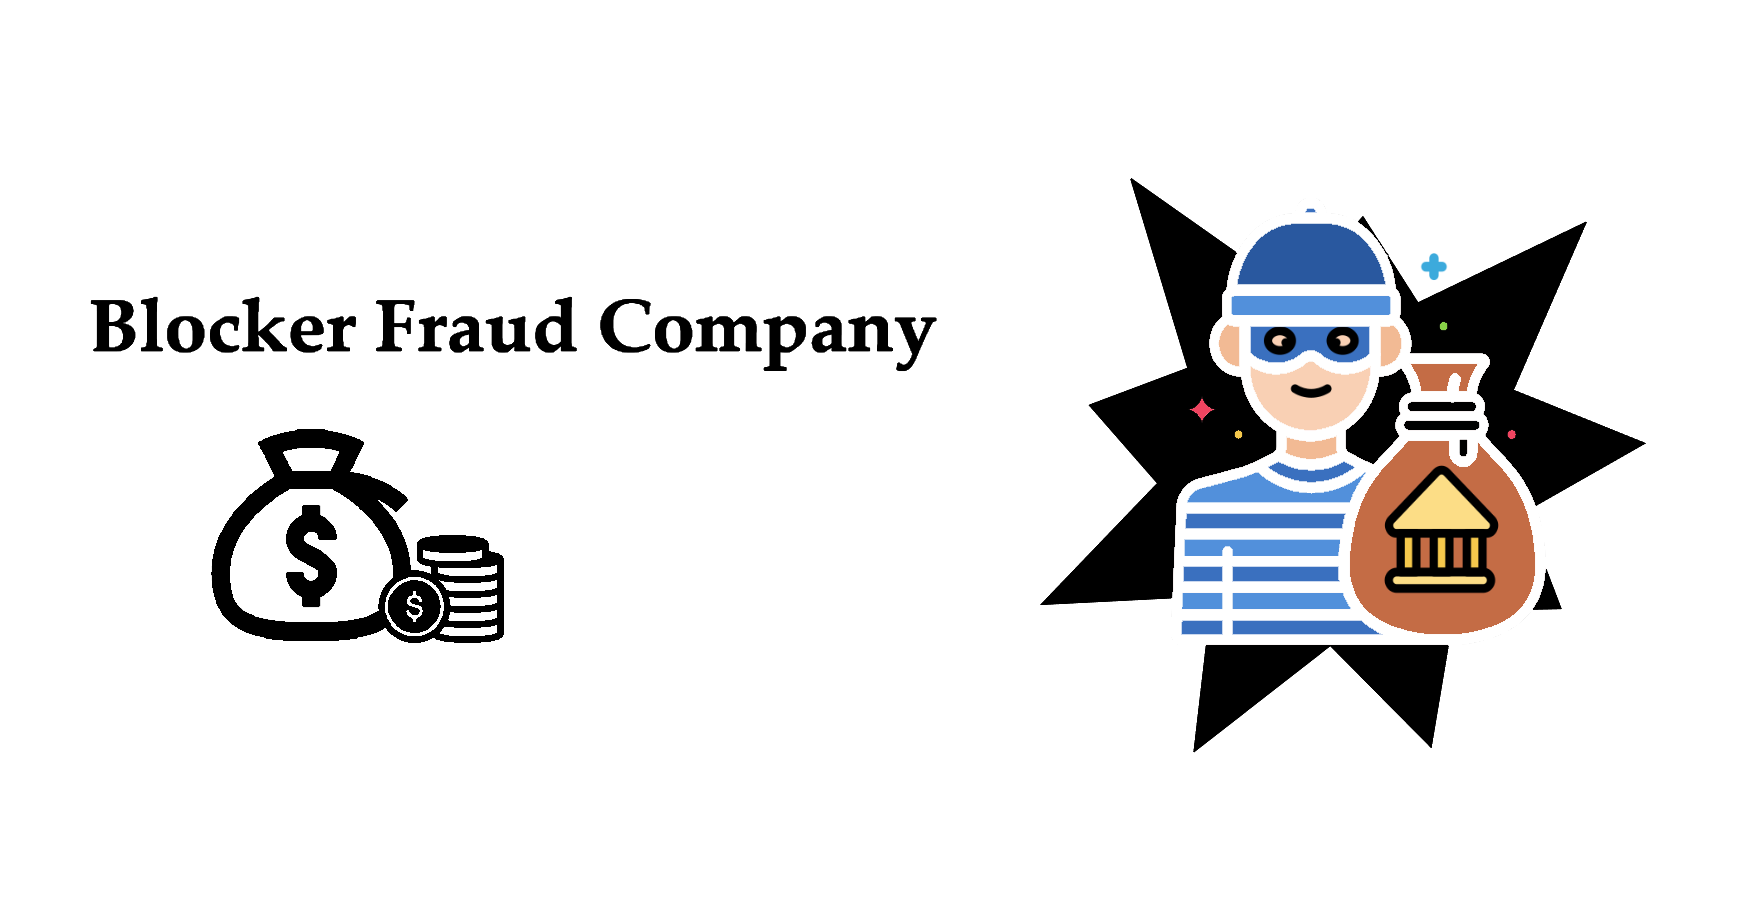

<p style="text-align:center;"><i>"Blocker Fraude Company is a company specialized in fraud detection in financial transactions made through mobile devices. The company has a service called “Blocker Fraud” with guarantee of blocking fraudulent transactions."</i></p>

**Bussiness Model**

The company's business model is of the service type with monetization made by the provider's performance, that is, the user pays a fixed fee on the success in the detection of service fraud of the customer's transactions.

In Brazil, the company start with a new method of services to get some new clients:

1. The company will receive **25%** of the value of each transaction that is **truly detected as fraud**.
2. The company will receive **5%** of the value of each transaction **detected as fraud, however the transaction is truly legitimate**.
3. The company will refund **100%** of the value to the customer, for each transaction **detected as legitimate, however the transaction is truly a fraud**.

**What is a Fraud?**

<i>"Wrongful or criminal deception intended to result in financial or personal gain."</i>~ Wiki

Fraud is an intentionally deceptive action designed to provide the perpetrator with an unlawful gain or to deny a right to a victim. In addition, it is a deliberate act (or failure to act) with the intention of obtaining an unauthorized benefit, either for oneself or for the institution, by using deception or false suggestions or suppression of truth or other unethical means, which are believed and relied upon by others. Depriving another person or the institution of a benefit to which he/she/it is entitled by using any of the means described above also constitutes fraud.

Types of fraud include tax fraud, credit card fraud, wire fraud, securities fraud, and bankruptcy fraud. Fraudulent activity can be carried out by one individual, multiple individuals or a business firm as a whole.

Source data set: https://www.kaggle.com/ntnu-testimon/paysim1

| Feature        | Description                                                                                                                                                                                                                                                                                           |
|:----------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| step           | maps a unit of time in the real world\. In this case 1 step is 1 hour of time\. Total steps 744 \(30 days simulation\)\.                                                                                                                                                                              |
| type           | Transaction type \(CASH\-IN, CASH\-OUT, DEBIT, PAYMENT and TRANSFER\)                                                                                                                                                                                                                                 |
| amount         | amount of the transaction in local currency                                                                                                                                                                                                                                                           |
| nameOrig       | customer who started the transaction                                                                                                                                                                                                                                                                  |
| oldbalanceOrg  | initial balance before the transaction                                                                                                                                                                                                                                                                |
| newbalanceOrig | new balance after the transaction                                                                                                                                                                                                                                                                     |
| nameDest       | customer who is the recipient of the transaction                                                                                                                                                                                                                                                      |
| oldbalanceDest | initial balance recipient before the transaction\. Note that there is not information for customers that start with M \(Merchants\)                                                                                                                                                                   |
| newbalanceDest | new balance recipient after the transaction\. Note that there is not information for customers that start with M \(Merchants\)                                                                                                                                                                        |
| isFraud        | This is the transactions made by the fraudulent agents inside the simulation\. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system |
| isFlaggedFraud | The business model aims to control massive transfers from one account to another and flags illegal attempts\. An illegal attempt in this dataset is an attempt to transfer more than 200K in a single transaction                                                                                 |

### 0.1. Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as ss
from inflection import underscore

from sklearn.model_selection import StratifiedShuffleSplit


from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, skewness, kurtosis, col, when, isnan, count
from pyspark.sql.types import StructField, StringType, ShortType, DoubleType, StructType, IntegerType

### 0.2. Aux Functions

In [72]:
warnings.filterwarnings('ignore')

def args_b(color=(1, 1, 1, 0), edgecolor='red', linewidth=3):
    return {'linewidth': linewidth, 'color': color, 'edgecolor': edgecolor}

palette = sns.diverging_palette(359, 359, n=5, s=999, l=50, center='dark')

def metrics(df, prop=.25, split=False):
    num_att = df.select_dtypes(include=['int16', 'float32'])
    cat_att = df.select_dtypes(include=['object', 'category'])
    
    if split:
        return num_att, cat_att
    
    else:        
        c1 = pd.DataFrame(num_att.apply(np.mean)).T
        c2 = pd.DataFrame(num_att.apply(np.median)).T
        d1 = pd.DataFrame(num_att.apply(min)).T
        d2 = pd.DataFrame(num_att.apply(max)).T
        d3 = pd.DataFrame(num_att.apply(np.std)).T
        d4 = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(num_att.apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T
        trim_mean = pd.DataFrame(ss.trim_mean(num_att.values, .25)).T
        trim_mean.columns = d6.columns.tolist()

        m = pd.concat([d1, d2, c1, c2, trim_mean, d3, d4, d5, d6], axis=0).T.reset_index()
        m.columns = ['att', 'min', 'max', 'mean', 'median', 'trim_mean', 'std', 'range', 'skew', 'kurtosis']

        return m
    
def simple_plot_bars(cat_values):
    _, _, = plt.subplots(figsize=(10,10))
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((2, 2), (1, 0))
    ax2 = plt.subplot2grid((2, 2), (1, 1))

    ax0.bar(cat_values[0].keys(), cat_values[0].values(), color='k')
    ax1.hist(cat_values[1].values(), bins=10, color='k')
    ax2.hist(cat_values[2].values(), bins=10, color='k')
    ax0.set_title('type')
    ax1.set_title('name_origin')
    ax2.set_title('name_dest');
    
    return None

In [19]:
# Startup PySpark Config
spark = SparkSession.builder.config("spark.driver.memory", "12g").appName('Fraud').getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enables", "true")

### 0.3. Load Dataset 

In [21]:
# defines the schema:      field,   type,   Null.
data_schema = [StructField('step', ShortType(), True), 
               StructField('type', StringType(), True),
               StructField('amount', DoubleType(), True),
               StructField('nameOrig', StringType(), True),
               StructField('oldbalanceOrg', DoubleType(), True),
               StructField('newbalanceOrig', DoubleType(), True),
               StructField('nameDest', StringType(), True),
               StructField('oldbalanceDest', DoubleType(), True),
               StructField('newbalanceDest', DoubleType(), True),
               StructField('isFraud', ShortType(), True),
               StructField('isFlaggedFraud', ShortType(), True)]

final_struct = StructType(fields=data_schema)

In [23]:
df_spark = spark.read.csv('../data/data.csv', schema=final_struct, header=True)

In [25]:
df_spark.printSchema()

root
 |-- step: short (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: short (nullable = true)
 |-- isFlaggedFraud: short (nullable = true)



In [15]:
df_default = pd.read_csv('../data/data.csv')

In [26]:
df_default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [2]:
dtypes = {'step': 'int16',
          'type': 'category',
          'amount': 'float32',
          'nameOrig': 'object',
          'oldbalanceOrg': 'float32',
          'newbalanceOrig': 'float32',
          'nameDest': 'object',
          'oldbalanceDest': 'float32',
          'newbalanceDest': 'float32',
          'isFraud': 'uint8',
          'isFlaggedFraud': 'uint8'}

df_pandas = pd.read_csv('../data/data.csv', dtype=dtypes)

In [3]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int16   
 1   type            category
 2   amount          float32 
 3   nameOrig        object  
 4   oldbalanceOrg   float32 
 5   newbalanceOrig  float32 
 6   nameDest        object  
 7   oldbalanceDest  float32 
 8   newbalanceDest  float32 
 9   isFraud         uint8   
 10  isFlaggedFraud  uint8   
dtypes: category(1), float32(5), int16(1), object(2), uint8(2)
memory usage: 248.8+ MB


In [4]:
df_pandas.sample()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1263167,134,CASH_IN,84805.5,C543757573,7330856.0,7415661.5,C231012766,1558012.625,1473207.125,0,0


### 0.4. Split Dataset in Train and Test

In [14]:
(df_pandas.isFraud.value_counts() / len(df_pandas))

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [16]:
strat = StratifiedShuffleSplit(n_splits=1, test_size=.15)
for train_index1, train_index2 in strat.split(df_pandas, df_pandas.isFraud):
    strat_train = df_pandas.loc[train_index1]
    strat_test  = df_pandas.loc[train_index2]

In [21]:
strat_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5408227 entries, 1528246 to 6295869
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int16   
 1   type            category
 2   amount          float32 
 3   nameOrig        object  
 4   oldbalanceOrg   float32 
 5   newbalanceOrig  float32 
 6   nameDest        object  
 7   oldbalanceDest  float32 
 8   newbalanceDest  float32 
 9   isFraud         uint8   
 10  isFlaggedFraud  uint8   
dtypes: category(1), float32(5), int16(1), object(2), uint8(2)
memory usage: 252.7+ MB


In [26]:
strat_train.isFraud.value_counts()

0    5401246
1       6981
Name: isFraud, dtype: int64

In [19]:
strat_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 954393 entries, 3666544 to 1626565
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   step            954393 non-null  int16   
 1   type            954393 non-null  category
 2   amount          954393 non-null  float32 
 3   nameOrig        954393 non-null  object  
 4   oldbalanceOrg   954393 non-null  float32 
 5   newbalanceOrig  954393 non-null  float32 
 6   nameDest        954393 non-null  object  
 7   oldbalanceDest  954393 non-null  float32 
 8   newbalanceDest  954393 non-null  float32 
 9   isFraud         954393 non-null  uint8   
 10  isFlaggedFraud  954393 non-null  uint8   
dtypes: category(1), float32(5), int16(1), object(2), uint8(2)
memory usage: 44.6+ MB


In [25]:
strat_test.isFraud.value_counts()

0    953161
1      1232
Name: isFraud, dtype: int64

In [28]:
strat_train.to_csv("../data_backup/df_train.csv")
strat_test.to_csv("../data_backup/df_test.csv")

# 1.0. Descriptive Statistical

In [4]:
dtypes = {'step': 'int16',
          'type': 'category',
          'amount': 'float32',
          'nameOrig': 'object',
          'oldbalanceOrg': 'float32',
          'newbalanceOrig': 'float32',
          'nameDest': 'object',
          'oldbalanceDest': 'float32',
          'newbalanceDest': 'float32',
          'isFraud': 'uint8',
          'isFlaggedFraud': 'uint8'}

df = pd.read_csv("../data_backup/df_train.csv", dtype=dtypes)
df = df.drop("Unnamed: 0", axis=1)
msk = (df.isFraud == 1)

## 1.1. Rename Columns

In [5]:
df.columns = [underscore(k) for k in df.columns.tolist()]

## 1.2. Dataset Dimension

In [6]:
print(f'Number of Columns: {df.shape[1]}\nNumber of Rows: {df.shape[0]}')

Number of Columns: 11
Number of Rows: 5408227


## 1.3. Change Data Types

In [7]:
df.dtypes

step                   int16
type                category
amount               float32
name_orig             object
oldbalance_org       float32
newbalance_orig      float32
name_dest             object
oldbalance_dest      float32
newbalance_dest      float32
is_fraud               uint8
is_flagged_fraud       uint8
dtype: object

## 1.4. Check NaN

In [8]:
df.isna().sum() / len(df)

step                0.0
type                0.0
amount              0.0
name_orig           0.0
oldbalance_org      0.0
newbalance_orig     0.0
name_dest           0.0
oldbalance_dest     0.0
newbalance_dest     0.0
is_fraud            0.0
is_flagged_fraud    0.0
dtype: float64

## 1.5. Fillout NaN

Do not have Missing Values

## 1.6. Change Data Types

Do not need change data types.

## 1.7. Undersampling Dataset

In [13]:
df.is_fraud.value_counts()

0    5401246
1       6981
Name: is_fraud, dtype: int64

In [18]:
df_samp = df.loc[df.is_fraud == 0].sample(7200)
df_samp = pd.concat([df_samp, df.loc[df.is_fraud == 1]], axis=0)
df_samp.head(3)

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
5392399,34,CASH_OUT,408470.46875,C486135548,29238.0,0.0,C375056093,5.212254e+05,9.296959e+05,0,0
843123,206,CASH_IN,85954.21875,C1200329934,8539690.0,8625644.0,C1176483839,1.483390e+05,6.238476e+04,0,0
3710458,132,CASH_OUT,348976.31250,C872262965,0.0,0.0,C302256620,2.288808e+06,2.300835e+06,0,0


In [20]:
df_samp.is_fraud.value_counts()

0    7200
1    6981
Name: is_fraud, dtype: int64

In [22]:
df_samp.to_csv("../data_backup/df_samp.csv")

## 1.8. Descriptive Statistical

### 1.8.1. Numerical Attributes

In [11]:
metrics(df)

,att,min,max,mean,median,trim_mean,std,range,skew,kurtosis
0,step,1.0,743.0,2.434009e+02,239.000000,243.825943,1.423186e+02,742.0,0.375442,0.330067
1,amount,0.0,92445520.0,1.799852e+05,74780.328125,86192.468750,6.067542e+05,92445520.0,31.065538,1797.876221
2,oldbalance_org,0.0,59585040.0,8.335407e+05,14179.000000,24526.994141,2.886164e+06,59585040.0,5.248106,32.961182
3,newbalance_orig,0.0,49585040.0,8.547692e+05,0.000000,18249.531250,2.921968e+06,49585040.0,5.175535,32.055901
4,oldbalance_dest,0.0,356015904.0,1.101134e+06,132240.562500,234946.015625,3.407695e+06,356015904.0,20.087791,964.457642
5,newbalance_dest,0.0,356179264.0,1.225712e+06,214286.859375,308879.687500,3.685985e+06,356179264.0,19.486113,871.897766


In [23]:
metrics(df_samp)

,att,min,max,mean,median,trim_mean,std,range,skew,kurtosis
0,step,1.0,743.0,3.060059e+02,283.000000,285.383148,1.937653e+02,742.0,0.441115,-0.607467
1,amount,0.0,23403230.0,8.097104e+05,171935.250000,200934.093750,1.836833e+06,23403230.0,3.720531,14.990998
2,oldbalance_org,0.0,59585040.0,1.226864e+06,114627.078125,193831.781250,3.238830e+06,59585040.0,5.912397,54.114948
3,newbalance_orig,0.0,49585040.0,5.248644e+05,0.000000,0.000000,2.500269e+06,49585040.0,7.715716,78.082573
4,oldbalance_dest,0.0,236230512.0,8.249208e+05,0.000000,88940.296875,3.308404e+06,236230512.0,31.467487,1918.489014
5,newbalance_dest,0.0,236726496.0,1.248158e+06,124481.023438,259071.890625,3.722717e+06,236726496.0,23.905994,1249.015503


#### 1.8.1.1. Newbalance Origin Analyze 

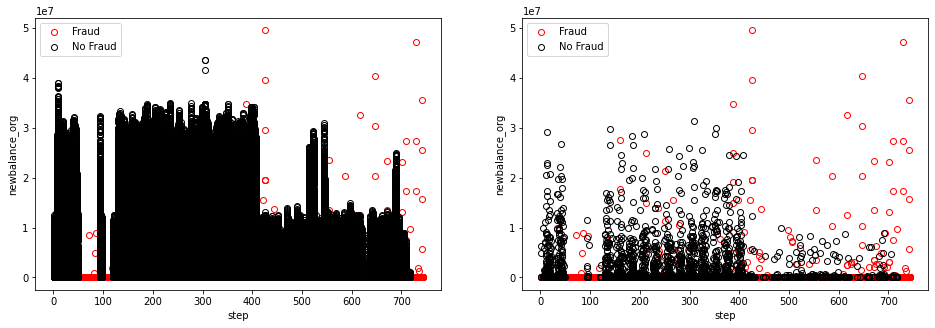

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
for d, k in zip([df, df_samp], [0, 1]):
    ax[k].scatter(d[msk]['step'], d[msk]['newbalance_orig'], **args_b(linewidth=1))
    ax[k].scatter(d[~msk]['step'], d[~msk]['newbalance_orig'], **args_b(linewidth=1, edgecolor='k'))
    ax[k].legend(['Fraud', 'No Fraud'])
    ax[k].set_xlabel('step')
    ax[k].set_ylabel('newbalance_org');

### 1.8.2. Categorical Attributes

#### 1.8.2.1. Sample Dataset

In [25]:
_, cat_att = metrics(df_samp, split=True)

cat_values = [cat_att[k].value_counts().to_dict() for k in cat_att.columns.tolist()]

In [28]:
cat_att.describe()

,type,name_orig,name_dest
count,14181,14181,14181
unique,5,14181,14057
top,CASH_OUT,C486135548,C721605153
freq,6044,1,2


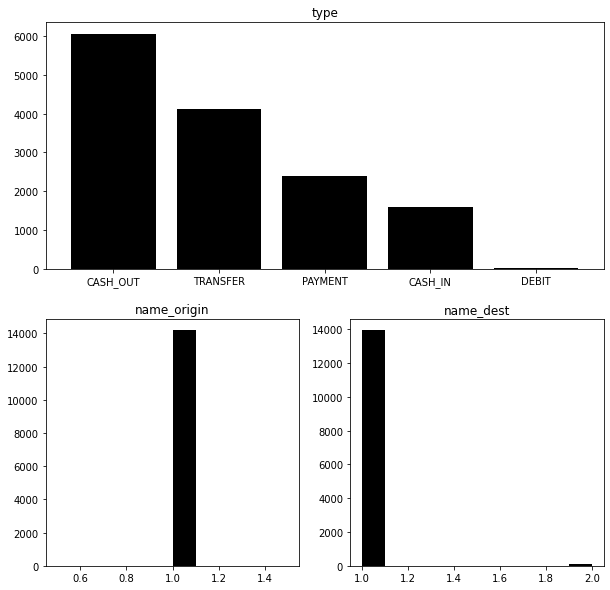

In [26]:
simple_plot_bars(cat_values);

#### 1.8.2.2. Full Dataset

In [29]:
_, cat_att = metrics(df, split=True)

cat_values = [cat_att[k].value_counts().to_dict() for k in cat_att.columns.tolist()]

In [31]:
cat_att.describe()

,type,name_orig,name_dest
count,5408227,5408227,5408227
unique,5,5401432,2382129
top,CASH_OUT,C724452879,C985934102
freq,1900990,3,97


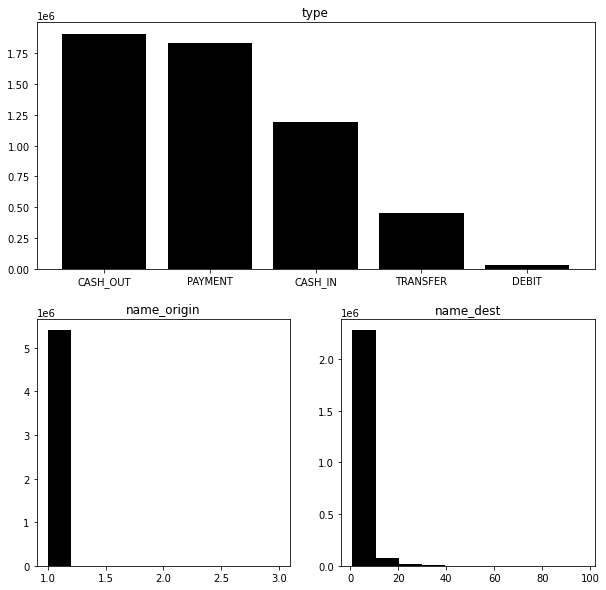

In [30]:
simple_plot_bars(cat_values);

In [74]:
(df.loc[df.type == 'CASH_OUT']).is_fraud.value_counts().to_dict()

{0: 1897480, 1: 3510}

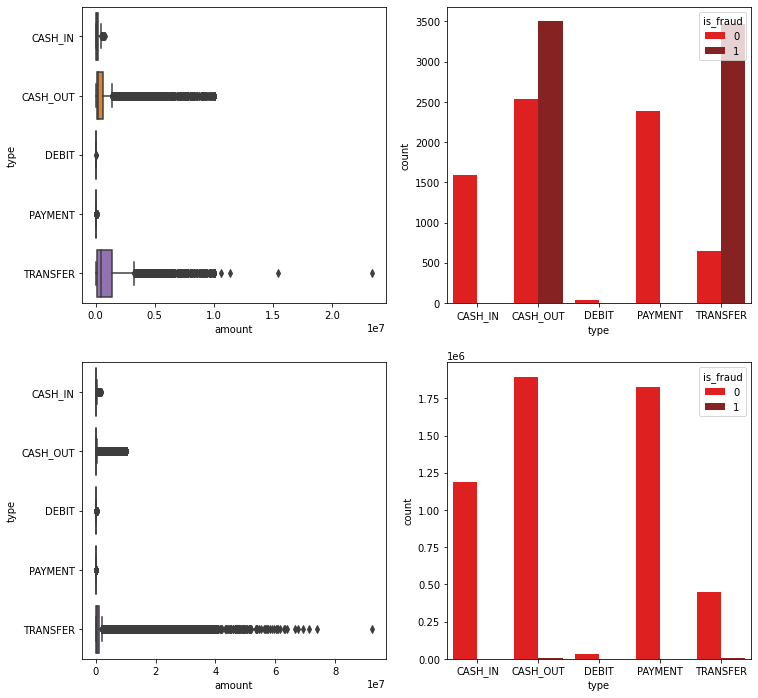

In [73]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()
for d, i in zip([df_samp, df], [[0, 1], [2, 3]]):
    sns.boxplot(d.amount, d.type, ax=ax[i[0]]);
    sns.countplot(d.type, hue=d.is_fraud, ax=ax[i[1]], palette=palette);

1. Debit is the lowest payment type basend on all 64kk rows.
2. Have people on Dataset with more than one transaction.
3. Have people with +50 Transactions!

In [75]:
# The Client C985934102 have 97 Transactions, all transactions are legitimate
(df.loc[df.name_dest == 'C985934102']).is_fraud.value_counts().to_dict()

{0: 97}

In [49]:
df[['name_orig', 'is_fraud']].groupby('name_orig').count().reset_index().sort_values('is_fraud', ascending=False).head(4)

,name_orig,is_fraud
3622106,C363736674,3
2189496,C1784010646,3
3724238,C400299098,3
2325136,C1832548028,3


In [48]:
df[['name_dest', 'is_fraud']].groupby('name_dest').count().reset_index().sort_values('is_fraud', ascending=False).head(4)

,name_dest,is_fraud
549279,C985934102,97
310094,C2083562754,95
81877,C1286084959,94
6747,C1023714065,88


# 2.0. Feature Engineering 

In [113]:
df2 = pd.read_csv("../data_backup/df_samp.csv")
df2 = df2.drop('Unnamed: 0', axis=1)

## 2.1. Mind Map

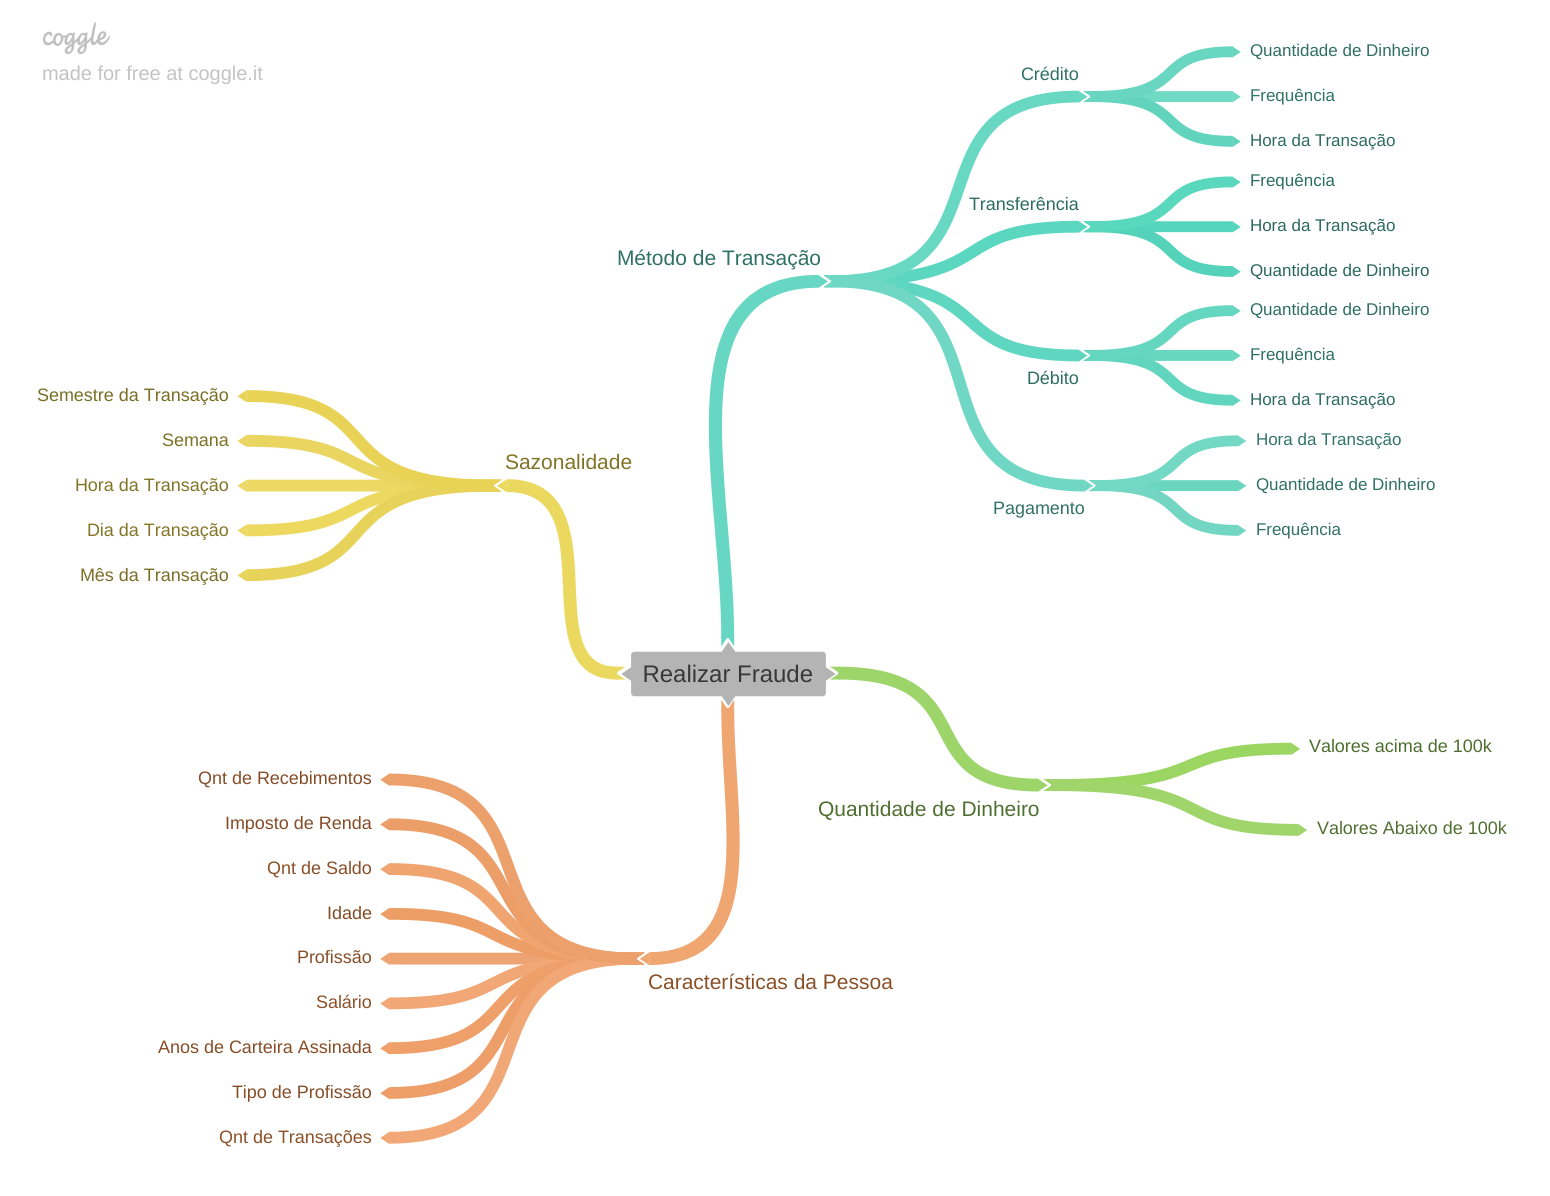

## 2.2. Hypothesis List 

Next Cycle 

## 2.3. Feature Engineering

In [115]:
# Day Feature

step = [1]+list(range(24, df2.step.max()+24, 24))
dates = [[k if k <= step[i] and k >= step[i-1] else 0 for k in df2.step] for i in range(len(step))]

df_date = pd.DataFrame(dates).T
df_date = df_date.drop(0, axis=1)

for k in df_date.columns.tolist():
    df_date[k] = df_date[k].apply(lambda x: k if x > 0 else 0)
    df_date[k] = df_date[k].replace(0, np.nan)
    df_date[1] = df_date[1].combine_first(df_date[k])

df2['day'] = df_date[1]

df2.day = df2.day.astype('int64')

In [117]:
df2.to_csv('../data_backup/df2_samp.csv')

# 3.0. Data Filtering

In First Cycle i will not filter nothing.